# Image Classification
In this lesson we will create a model to solve an image classification problem. We will use a standard Dataset to do this as it will enable us to learn about how we build models to perform classificaiton using image data.

The dataset consists of a number of images of hand written digits knowna as MNIST dataset, it is somewhat old and generally considered straightforward to solve by today's standards. However, it's a good teaching dataset.

# Importing some packages
We are using the Python programming language and a set of Machine Learning packages - Importing packages for use is a common task. For this workshop you don't really need to pay that much attention to this step (but you do need to execute the cell) since we are focusing on building models. However the following is a description of what this cell does that you can read if you are interested.

### Description of imports (Optional)
You don't need to worry about this code as this is not the focus on the workshop but if you are interested in what this next cell does, here is an explaination.

|Statement|Meaning|
|---|---|
|__import os__|This is a standard Python library to work with the file system|
|__import tensorflow as tf__ |Tensorflow (from Google) is our main machine learning library and we performs all of the various calculations for us and so hides much of the detailed complexity in Machine Learning. This _import_ statement makes the power of TensorFlow available to us and for convience we will refer to it as __tf__ |
|__from tensorflow import keras__ |Tensorflow is quite a low level machine learning library which, while powerful and flexible can be confusing so instead we use another higher level framework called Keras to make our machine learning models more readable and easier to build and test. This _import_ statement makes the Keras framework available to us.|
|__import numpy as np__ |Numpy is a Python library for scientific computing and is commonly used for machine learning. This _import_ statement makes the Keras framework available to us.|
|__import pandas as pd__|Pandas is a library that helps us manipulate tables of data. We import this|
|__import seaborn as sns__|Seaborn is a library that created very useful visualisations|
|__import matplotlib.pyplot as plt__ |To visualise what is happening in our network we will use a set of graphs and MatPlotLib is the standard Python library for producing Graphs so we __import__ this to enable us to make pretty graphs.|
|__%matplotlib inline__| this is a Jupyter Notebook __magic__ commmand that tells the workbook to produce any graphs as part of the workbook and not as pop-up window.|

In [19]:
# Import the packages we need
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

%matplotlib inline

## Helper functions
The following cell contains a set of helper functions that makes our models a little clearer. We will not be going through these functions (since they require Python knowlege) so just make sure you have run this cell.

In [31]:
def printSampleImages(image_data, image_labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_data[i], cmap=plt.cm.binary)
        plt.xlabel(image_labels[i])
    plt.show()

def displayLossAndAccuracy(history):
  plt.plot(history.history['loss'], color='red', label='Loss')
  plt.plot(history.history['accuracy'], color='blue', label='Accuracy')
  plt.legend()
  plt.grid(b=True, which='major', color='#666666', linestyle='-')
  plt.show()

def printSingleImage(image_data, image_labels, image_index, title=""):
  plt.imshow(image_data[image_index], cmap=plt.cm.binary)
  plt.xlabel(image_labels[image_index])
  if len(title) > 0 :
    plt.title(title)
  plt.show()

def printSampleIncorrectImages(image_data, image_labels, model):
    incorrects = np.nonzero(model.predict_classes(image_data).reshape((-1,)) != image_labels)
    
    plt.figure(figsize=(10,10))
    max_items = 25 if len(incorrects[0]) > 25 else len(incorrects[0])
    for i in range(max_items):
        incorrect_image_index = incorrects[0][i]
        incorrect_image_data = np.array([image_data[incorrect_image_index]])
        expected_class = image_labels[incorrect_image_index]
        predicted_class = model.predict_classes(incorrect_image_data)
        errorTitle = "Expected class: '%d'\nPredicted class: '%d'"%(expected_class, predicted_class)
    
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.tight_layout()
        plt.imshow(image_data[incorrect_image_index], cmap=plt.cm.binary)
        plt.xlabel(errorTitle)
    plt.show()

def displayConfusionMatrix(expected, predicted):
  import seaborn as sn
  from sklearn.metrics import confusion_matrix

  confusion_matrix = confusion_matrix(y_true = expected, y_pred = predicted)
  plt.figure(figsize=(12,8))
  ax = plt.subplot()
  sn.heatmap(confusion_matrix, annot=True, ax = ax)
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('Actual labels'); 
  ax.set_title('Confusion Matrix'); 

  plt.show()

## The MNIST Dataset
MNIST is a standard dataset and is still frequently used - it consists of a set of greyscale images, each 28 x 28 pixels. As a first venture into Machine Learning with images it is ideal but we will soon move onto more challenging datasets.

Since MNIST is used so frequently, Tensorflow and Keras provide easy access to the dataset and event, helpfully, split the data into training and testing sets for us. In Tensorflow, we just import the dataset with:

`from tensorflow.keras.datasets import mnist`

We can then load the data using:

`(x_train, y_train), (x_test, y_test) = mnist.load_data()`

Let's import the data and have a look at some examples.

In [21]:
# The data is loaded and pre-allocated into Training and Testing dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

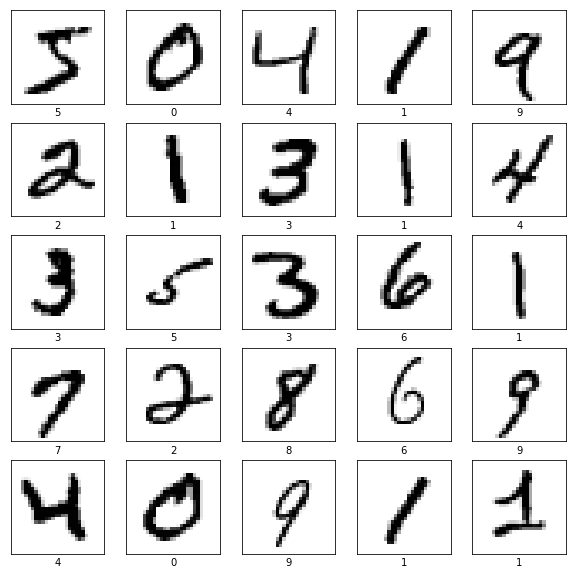

In [22]:
# Display some of the Training Data samples
printSampleImages(x_train, y_train)

## Exercise
If you take a digit such as the number 3 - How would you define a set of rules that describe how to recognise the number 3?

## What the machine sees
The above images have been constructed from the MNIST data so that we, as humans, can intrepret what they represent. However, machines don't understand images in the same way as a human does. Machines only understand numbers.

The data we are seeing in the images above are actually a collection of values, one for each of the 28x28 pixels. The numbers are in the range 0-255 where 0 indicates a white pixel and 255 indicates a black pixel. Numbers within this range (e.g. 128) are a shade of grey.

Let's see what the machine will use

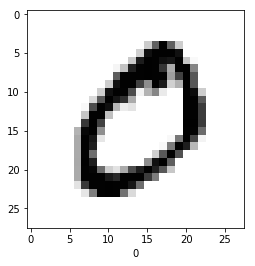

[  0   0   0   0   0   0  76 246 252 112   0   0   0   0   0   0   0   0
   0   0 253 252 148   0   0   0   0   0]


In [23]:
image_id = 1
# This is what we see
printSingleImage(x_train, y_train, image_id)

# This is the 15th row of the data that the machine uses
print(x_train[image_id][15])

## Data Pre-Processing and Normalisation
As before we need to consider Data Pre-Processing and Normalisation.

Given this is a standard Dataset we typically don't need to do any data pre-processing since the images are all the same size and the Object of Interest is centered in the image.

The pixel values are all in the same range (0 - 255) so we don't need to bring the features into similar ranges.

However, the range 0-255 is quite large and when we begin multiplying numbers they can quickly get large so we typically normalise the values into a range between 0 and 1. This will retain the proportional distance between values but just changes the scale.

The image itself will not be altered but will appear lighter.

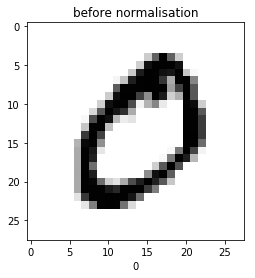

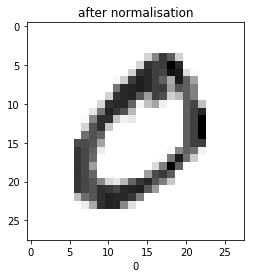

In [24]:
printSingleImage(x_train, y_train, image_id, title="before normalisation")

# Normalise the data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

printSingleImage(x_train, y_train, image_id, title="after normalisation")

In [25]:
# The raw data looks like this
np.set_printoptions(precision=3)
print(x_train[image_id][15])

[0.    0.    0.    0.    0.    0.    0.34  0.34  0.324 0.173 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.303 0.361 0.363 0.
 0.    0.    0.    0.   ]


## Building an Image Classifer Model 
In this exercise we will build and train a model to classify an image representing a handwritten digit (0 to 9) and classify it as being part of a numerical calss 0 to 9.

Essentially we are mapping the image represenation of a number to the number it represents.

In this exercise we will be using the same type of network as we did during the Prediction Exercises; that is to say a network based on Dense layers. In future exercises we will look at more specialised layers.

There are two key differences with this model:
- Each training sample consists of 28 rows of data each with 28 values; previously our data only had a single row of data.
- We are no longer predicting a single real value (e.g. 3.14) but instead we want to predict the category the image belongs to.

### Flattening our Data into a single row
Our training samples each contain 28 rows of data (each with 28 values) but we want our Dense layer to accept a single row of data.

We can flatten our training sample into a single row but concatenating each row of a training sample together. We can do this as part of our input layer using:

`model.add(tf.keras.layers.Flatten(input_shape=(28,28)))`

This is a specialised Keras Layer that takes an input of a given shape and flattens it into a single row of data.

Once flattened we can work with the data in other layers as before.

### Question
Each of our training samples consists of 28x28 pixels which are represented as a grid of numbers. How many features does our training example have?

### Categorising vs Predicting
Previously our output layer looked something like this:

`model.add(keras.layers.Dense(1))`

This specifies that we want a single node on the layer and since we have not specified an activation function we want the raw value. This is appropriate for predicting a real value such as was needed in the Taxi Fare Prediction problem.

In our Image Classification Problem we don't want a real value but instead we want a classification. For example, if the image is of a '3' we don't want a prediction of '3.2' we want a predicted category of '3'

The achieve this we need to do 2 things:
- Specify how many categories we have - each of these becomes a node in the output layer
- Use an activation function that categorises data into buckets

### Question
How many Categories do we need?

### Softmax activation function
When we want to categorise outputs we can use the Softmax activation function; this has the property of producing a set of probabilities across the set of categories for an input. The set of properties all add up to 1. So we can view this as telling us how likely an input belongs to each category. The larger the probability is for a category the more likely it is that the input belongs to that category.

In Keas we specify activation functions using the _activation_ parmeter in a layer definition as such:

`model.add(tf.keras.layers.Dense(units=5, activation=tf.nn.softmax))`

The number of units indicates how many categories we want to predict across - in the above example it is 5.

An explanation of the Softmax function is beyond the scope of this course but if you want to dive deeper into the SoftMax function then https://medium.com/data-science-bootcamp/understand-the-softmax-function-in-minutes-f3a59641e86d is a good introduction.


## Build your Image Classifer Model
You should now be able to create an image classifer based on your experiences of building models before and the information above.

### Exercise
The started code is below and you should discuss with your team the range of network architctures you want to try (single or multiple hidden layers, numbers of units on each layer etc.). 

You will also need to specify the number of categories on the output layer and the shape of the input on the input layer.

In [28]:
model  = tf.keras.Sequential()

# Input Layer - This layer flattens our 28x28 images into a stream of 784 numbers
# TODO: change input_shape=(None,None) to the correct input shape
model.add(tf.keras.layers.Flatten(input_shape=(None, None)))

# Hidden Layers
# TODO: Add one or more hidden layers
model.add(None)

# Output Layer
# TODO: Specify the number of categories to classify across
model.add(tf.keras.layers.Dense(units=None, activation=tf.nn.softmax))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


## Train your model
We will train our model for up to 100 epochs but we will include a callback to stop early if our validation loss stalls.

We are also using a validation_split of 20%; this means that a random 20% of our training samples will be used to validate our learning as we go.

In [29]:
## Train your model
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(x_train, y_train, epochs=100, validation_split = 0.2, callbacks=[early_stop])

W0927 10:17:42.643272 11416 deprecation.py:323] From C:\Users\Bill\Anaconda3\envs\ai\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 5s 96us/sample - loss: 0.2959 - accuracy: 0.9141 - val_loss: 0.1534 - val_accuracy: 0.9547
Epoch 2/50
48000/48000 [==============================] - 4s 87us/sample - loss: 0.1222 - accuracy: 0.9621 - val_loss: 0.1191 - val_accuracy: 0.9647
Epoch 3/50
48000/48000 [==============================] - 4s 86us/sample - loss: 0.0823 - accuracy: 0.9740 - val_loss: 0.1117 - val_accuracy: 0.9664
Epoch 4/50
48000/48000 [==============================] - 4s 76us/sample - loss: 0.0581 - accuracy: 0.9814 - val_loss: 0.0936 - val_accuracy: 0.9722
Epoch 5/50
48000/48000 [==============================] - 4s 80us/sample - loss: 0.0448 - accuracy: 0.9860 - val_loss: 0.1020 - val_accuracy: 0.9706
Epoch 6/50
48000/48000 [==============================] - 4s 84us/sample - loss: 0.0346 - accuracy: 0.9891 - val_loss: 0.1028 - val_accuracy: 0.9718
Epoch 7/50
48000/48000 [==============================] 

# Evaluating our Model

### Exercise
Run the cell below to produce a graph of the Training Accuracy and Loss during training, look at the graph and then answer the following questions?

Remember:
- __Training Loss__ is a measure of how well the predicted values match the expected values for the data used to train the model
- __Training Accuracy__ is the percentage of how training images the model correctly classified.

- What pattern do you you observe?
- Do you think if we train for longer we will improve the accuracy?
    - If you are not sure try re-running the cell above where we trained our model and see what happens

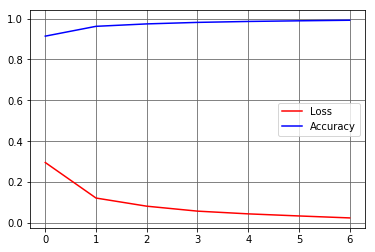

In [32]:
# summarize history for loss and accuracty across epochs
displayLossAndAccuracy(history)

### Exercise: Is this good enough?
So our __Accuracy__ against previously unseen data is about 95% but how do we know if this is any good? One way is to consider how well a Human might do on the same task (__Human Level Performance__)

If you were asked to categorise the hand written digits, would you be 100% accurate? If not what percentage do you think you would achieve?

Discuss this in groups to:
1. Agree on an accuracy percentage for Human Level Performance on this task.
2. List some problems you think a Human might have with this task.

# What is our model getting wrong
Let's look at what our model is getting wrong to see if we think this is acceptable errors or not when compared to Human Level Performance.

One way to investigate this is to look at the what our model is getting wrong at a class level. We can use a __Confusion Matrix__ for this purpose. A _Confusion Matrix_ displays how our model performed against the expected outcomes. 

In a good model we should see high values on the leading diagonal (left to right diagonal) and much lower values everywhere else.

Let's generate a Confusion Matrix.

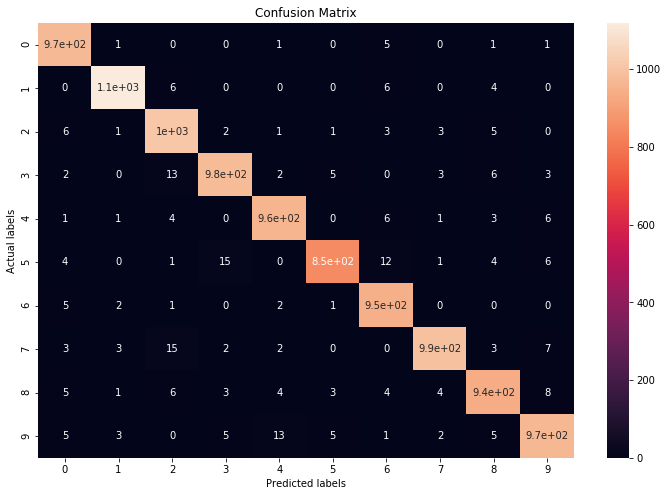

In [33]:
# Generate our predictions
test_predictions = model.predict_classes(x_test)

# Display a Confusion Matrix
displayConfusionMatrix(y_test, test_predictions)

### Exercise
Examine the _Confusion Matrix_ above - our model has made some classification mistakes. Look at the higher values and consider:
- Which _confusions_ are ones that a Human is likely to make sometimes
- Which _confusions_ are ones that a Human is unlikely to make often
- Which _confusions_ are ones that a Human is highly unlikely to ever make

### What images are confusing our model
Another approach is to view the images that the model is confused on and see if we think these are genuine mistakes or something else.

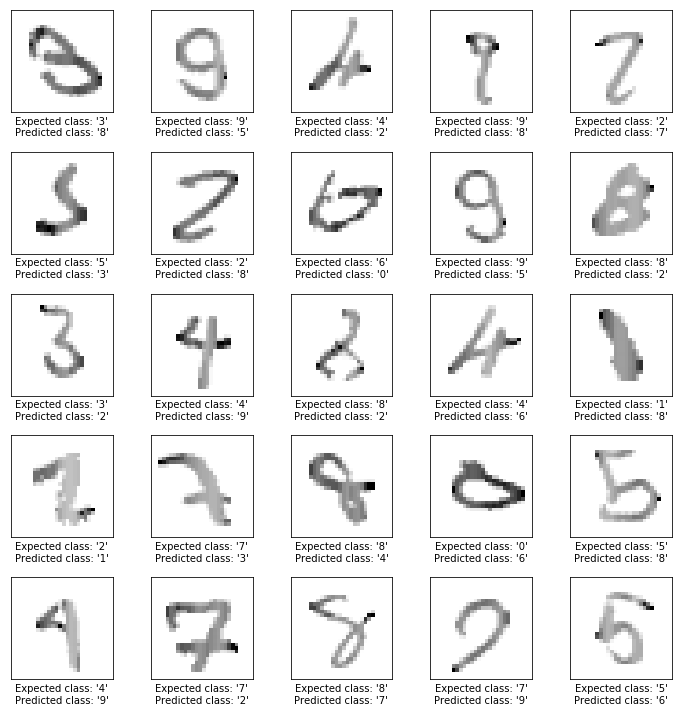

In [34]:
printSampleIncorrectImages(x_test, y_test, model)

### Exercise
Review the images above showing incorrectly predicted samples - compared to human level performance on a sample level how well do you think the model has done?

Are there images that you would have expected a human to correctly identify but the machine was wrong.

Consider the following use case:
We use our model as part of a system that scans mail items and based on the labelled destination code (handwritten or printed) we route the package to a desk for sorting. 

- Is the performance of this model good enough for this purpose?

A Destination Code is a 5 digit number that has some structure and not all 5 digit combinations are valid. How could we use the information in our model to improve the effectiveness of the routing?


# Key Observations
The following are key observations to note before we move on
1. An NNs learn to classify images in a very different way to humans
    - More generally, NNs learn differently to humans
    - In this example we treated the image as a sequence of numbers so lost some spacial information.
    - The learning is based purely on numerical values and computations
    - __BUT__ that doesn't mean it's not useful
2. Deeper Networks tend to have a greater capacity to learn more complex relationships between inputs and outputs.
3. We need to _test_ our model on unseen data to get a better idea of how well it has trained
4. Simple metrics such as Accuracy are good indicators but further investigation and testing may be required.
5. Sometimes machines struggle to classify correctly the same as a human.
    - They fail in ways that a human wouldn't